In [1]:
#Aadit Jerfy // Alzheimer's & Brain Tumor Detection via MRI
import pandas as pd
import numpy as np
import os
from mpl_toolkits.axes_grid1 import ImageGrid # for plotting the images as graphs

import cv2 # masking images
from glob import glob

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from keras.layers import InputLayer, MaxPooling2D, Flatten, Dense, Conv2D, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50  #VGG-16
from tensorflow.keras.optimizers import Adam, SGD # (adagrad + momentum)  SGD-->(stochastic gradient descent)
from tensorflow.keras import backend as K #cache 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL.Image import open

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from tensorflow.keras.models import Model, load_model, save_model  # controls modelling
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten

import seaborn as sns
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline

In [2]:
# Constants
IMAGE_DATASET = "../input/brain-tumor/Brain Tumor/Brain Tumor"
IMAGE_DATASET_RAW = r"..\input\brain-tumor\Brain Tumor\Brain Tumor"
WORKING_FOLDER = "/kaggle/working"
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS = 50

In [3]:
# We will import the csv file containing the features and the classes of the images
cortex_df = pd.read_csv("../input/brain-tumor/Brain Tumor.csv")
cortex_df.head()

Image  Class      Mean     Variance  Standard Deviation   Entropy  \
0  Image1      0  6.535339   619.587845           24.891522  0.109059   
1  Image2      0  8.749969   805.957634           28.389393  0.266538   
2  Image3      1  7.341095  1143.808219           33.820234  0.001467   
3  Image4      1  5.958145   959.711985           30.979219  0.001477   
4  Image5      0  7.315231   729.540579           27.010009  0.146761   

   Skewness   Kurtosis    Contrast    Energy       ASM  Homogeneity  \
0  4.276477  18.900575   98.613971  0.293314  0.086033     0.530941   
1  3.718116  14.464618   63.858816  0.475051  0.225674     0.651352   
2  5.061750  26.479563   81.867206  0.031917  0.001019     0.268275   
3  5.677977  33.428845  151.229741  0.032024  0.001026     0.243851   
4  4.283221  19.079108  174.988756  0.343849  0.118232     0.501140   

   Dissimilarity  Correlation     Coarseness  
0       4.473346     0.981939  7.458341e-155  
1       3.220072     0.988834  7.458341e-155  
2       5.981800     0.978014  7.458341e-155  
3       7.700919     0.964189  7.458341e-155  
4       6.834689     0.972789  7.458341e-155

In [4]:
cortex_df.shape

(3762, 15)

In [5]:
df = cortex_df.corr()
df

Class      Mean  Variance  Standard Deviation  \
Class               1.000000 -0.095729  0.308818            0.285568   
Mean               -0.095729  1.000000  0.783027            0.790984   
Variance            0.308818  0.783027  1.000000            0.975699   
Standard Deviation  0.285568  0.790984  0.975699            1.000000   
Entropy            -0.778180 -0.099729 -0.344432           -0.345127   
Skewness            0.402644 -0.601593 -0.347399           -0.425428   
Kurtosis            0.239844 -0.358163 -0.248312           -0.329798   
Contrast            0.212643 -0.050974  0.135494            0.117981   
Energy             -0.862413 -0.014863 -0.335470           -0.331103   
ASM                -0.758255 -0.109393 -0.341061           -0.342530   
Homogeneity        -0.847529  0.095556 -0.290527           -0.288801   
Dissimilarity       0.556319 -0.113864  0.235487            0.224773   
Correlation        -0.108601  0.293693  0.288037            0.354161   
Coarseness               NaN       NaN       NaN                 NaN   

                     Entropy  Skewness  Kurtosis  Contrast    Energy  \
Class              -0.778180  0.402644  0.239844  0.212643 -0.862413   
Mean               -0.099729 -0.601593 -0.358163 -0.050974 -0.014863   
Variance           -0.344432 -0.347399 -0.248312  0.135494 -0.335470   
Standard Deviation -0.345127 -0.425428 -0.329798  0.117981 -0.331103   
Entropy             1.000000 -0.222222 -0.140125 -0.140769  0.971260   
Skewness           -0.222222  1.000000  0.899713  0.349856 -0.295413   
Kurtosis           -0.140125  0.899713  1.000000  0.296664 -0.172454   
Contrast           -0.140769  0.349856  0.296664  1.000000 -0.130708   
Energy              0.971260 -0.295413 -0.172454 -0.130708  1.000000   
ASM                 0.999213 -0.209289 -0.133741 -0.139276  0.961628   
Homogeneity         0.852019 -0.470054 -0.307314 -0.270119  0.915988   
Dissimilarity      -0.502363  0.511931  0.375939  0.761497 -0.545774   
Correlation         0.122080 -0.570919 -0.589211 -0.427443  0.123680   
Coarseness               NaN       NaN       NaN       NaN       NaN   

                         ASM  Homogeneity  Dissimilarity  Correlation  \
Class              -0.758255    -0.847529       0.556319    -0.108601   
Mean               -0.109393     0.095556      -0.113864     0.293693   
Variance           -0.341061    -0.290527       0.235487     0.288037   
Standard Deviation -0.342530    -0.288801       0.224773     0.354161   
Entropy             0.999213     0.852019      -0.502363     0.122080   
Skewness           -0.209289    -0.470054       0.511931    -0.570919   
Kurtosis           -0.133741    -0.307314       0.375939    -0.589211   
Contrast           -0.139276    -0.270119       0.761497    -0.427443   
Energy              0.961628     0.915988      -0.545774     0.123680   
ASM                 1.000000     0.837139      -0.491813     0.121054   
Homogeneity         0.837139     1.000000      -0.746675     0.198639   
Dissimilarity      -0.491813    -0.746675       1.000000    -0.393013   
Correlation         0.121054     0.198639      -0.393013     1.000000   
Coarseness               NaN          NaN            NaN          NaN   

                    Coarseness  
Class                      NaN  
Mean                       NaN  
Variance                   NaN  
Standard Deviation         NaN  
Entropy                    NaN  
Skewness                   NaN  
Kurtosis                   NaN  
Contrast                   NaN  
Energy                     NaN  
ASM                        NaN  
Homogeneity                NaN  
Dissimilarity              NaN  
Correlation                NaN  
Coarseness                 NaN

Text(0.5, 1.0, 'Correlation between the parameters')

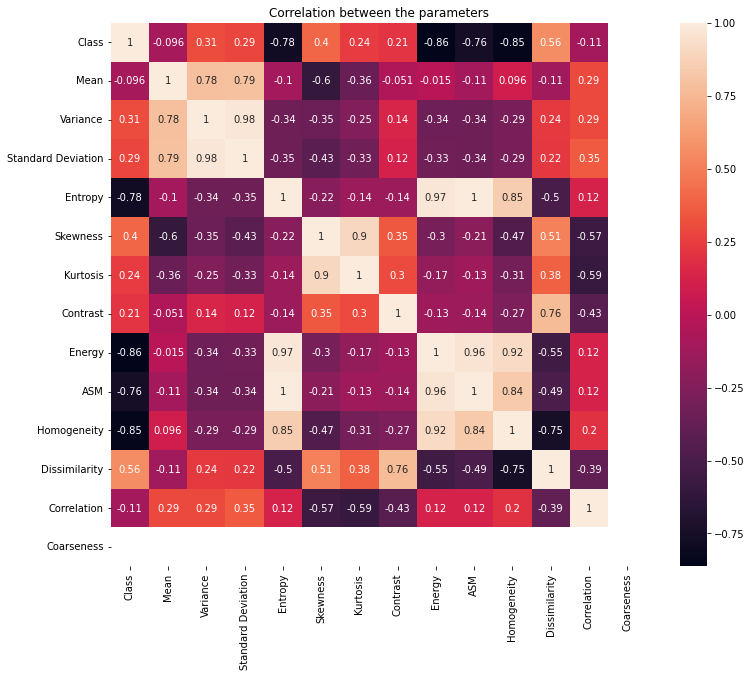

In [6]:
plt.figure(figsize=(12,10))
sns.heatmap(df,annot=True)
plt.title('Correlation between the parameters')  # Spearman's Matrix

In [7]:
# Set parameters
IMAGE_SIZE = (256, 256) 

In [8]:
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
train_files = [file.replace('_mask', '') for file in mask_files]

In [9]:
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image_path": train_files,
                   "mask_path": mask_files,
                  "diagnosis":[diagnosis(x) for x in mask_files]})
df.head()

image_path  \
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                           mask_path diagnosis  
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...         0  
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...         0  
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...         1  
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...         1  
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...         1

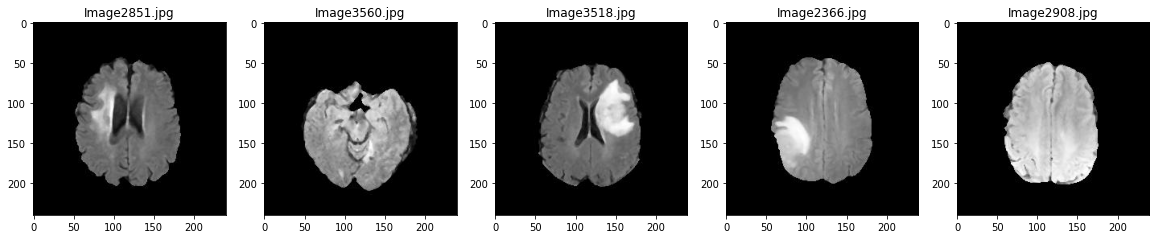

In [10]:
plt.figure(figsize=(20,20))
test_folder="../input/brain-tumor/Brain Tumor/Brain Tumor" 
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [11]:
dataset_df = pd.DataFrame()
dataset_df["Image"] = cortex_df["Image"]
dataset_df["Class"] = cortex_df["Class"]
path_list = []
for img_path in os.listdir(IMAGE_DATASET):
    path_list.append( os.path.join(IMAGE_DATASET,img_path))
path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
dataset_df["paths"] = cortex_df["Image"].map(path_dict.get)
dataset_df["pixels"] = dataset_df["paths"].map(lambda x:np.asarray(open(x).resize((IMG_HEIGHT,IMG_WIDTH))))
dataset_df.head()

Image  Class                                              paths  \
0  Image1      0  ../input/brain-tumor/Brain Tumor/Brain Tumor/I...   
1  Image2      0  ../input/brain-tumor/Brain Tumor/Brain Tumor/I...   
2  Image3      1  ../input/brain-tumor/Brain Tumor/Brain Tumor/I...   
3  Image4      1  ../input/brain-tumor/Brain Tumor/Brain Tumor/I...   
4  Image5      0  ../input/brain-tumor/Brain Tumor/Brain Tumor/I...   

                                              pixels  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

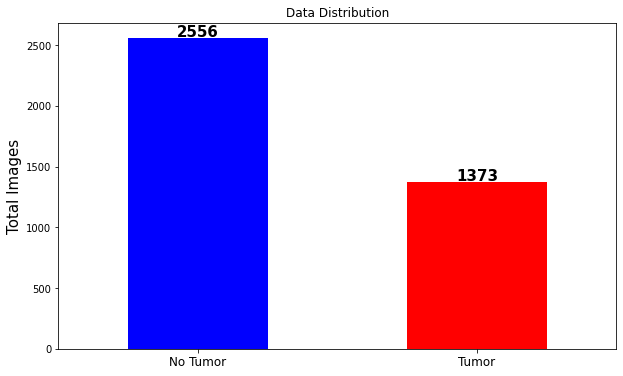

In [12]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

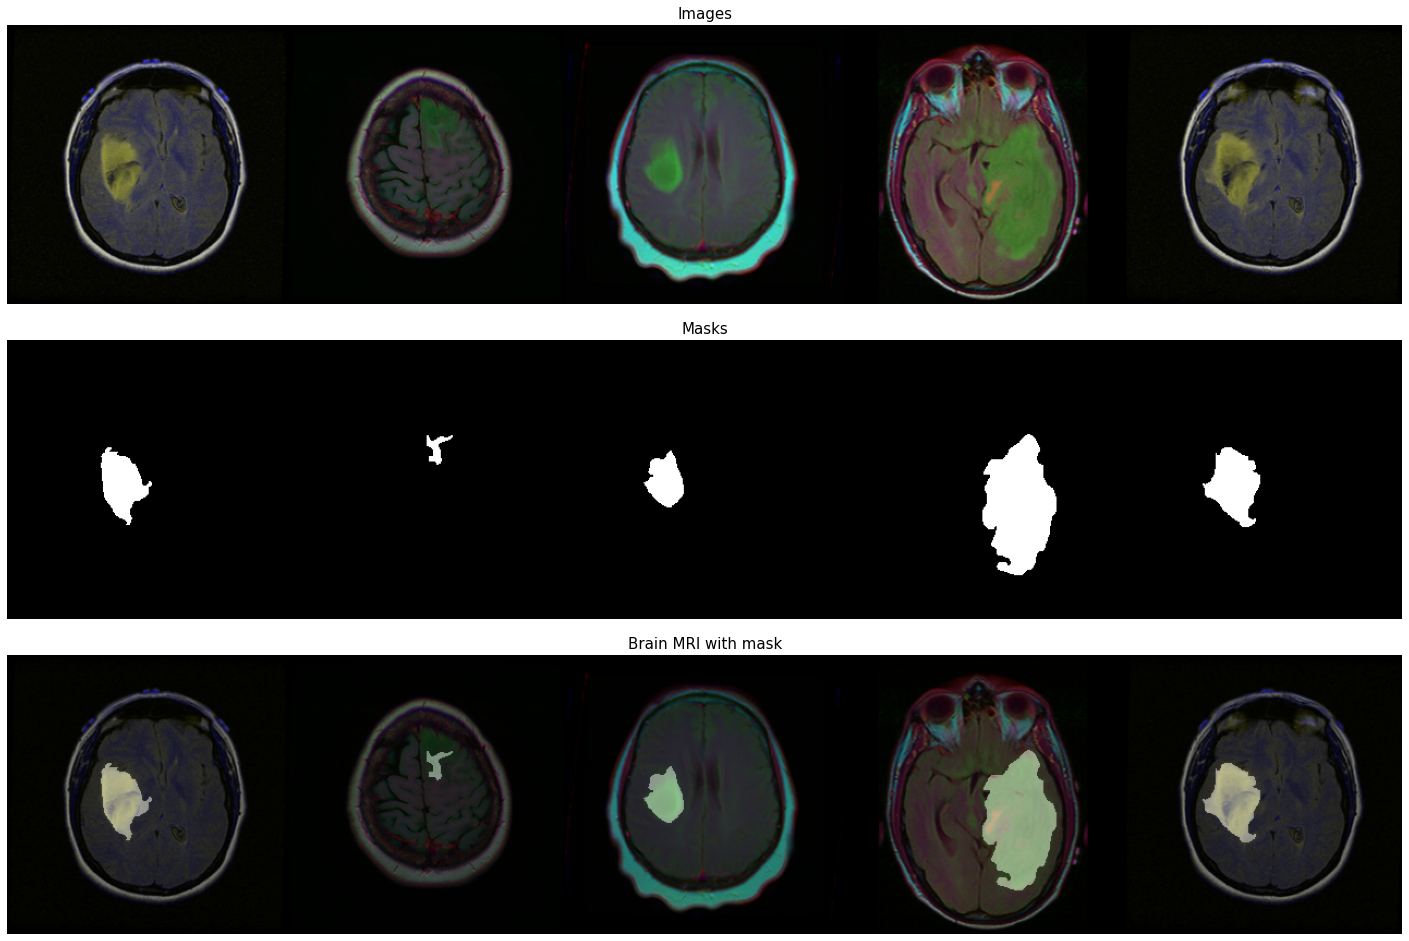

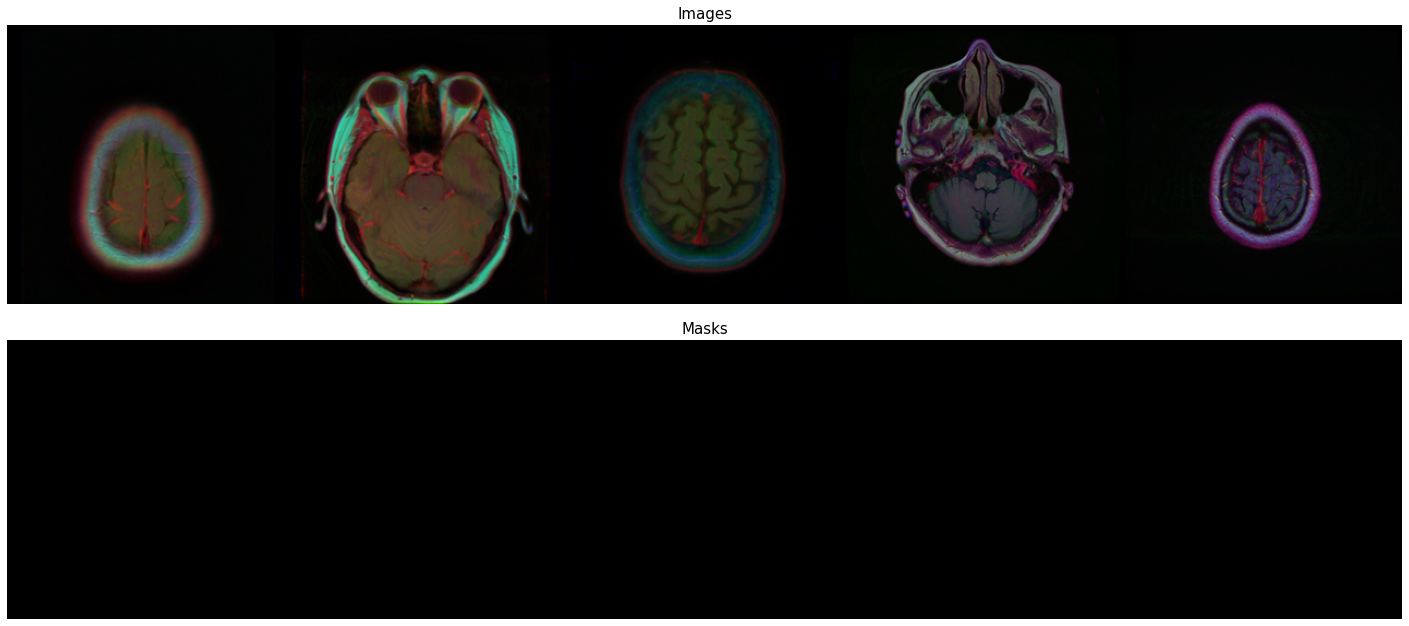

In [13]:
df_positive = df[df['diagnosis']=='1'].sample(5).values  # cases where tumor is found
df_negative = df[df['diagnosis']=='0'].sample(5).values  # cases where tumor is not found

def show_data(df, positive=True):
    images = []
    masks = []
    for data in df:
        img = cv2.imread(data[0])
        mask = cv2.imread(data[1])
        images.append(img)
        masks.append(mask)
    images = np.hstack(np.array(images))
    masks = np.hstack(np.array(masks))
    
    fig = plt.figure(figsize=(25,25))
    if positive:
        grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)
    else:
        grid = ImageGrid(fig, 111, nrows_ncols=(2,1), axes_pad=0.5)
    grid[0].imshow(images)
    grid[0].set_title('Images', fontsize=15)
    grid[0].axis('off')
    grid[1].imshow(masks)
    grid[1].set_title('Masks', fontsize=15)
    grid[1].axis('off')
    if positive:
        grid[2].imshow(images)
        grid[2].imshow(masks, alpha=0.4)
        grid[2].set_title('Brain MRI with mask', fontsize=15)
        grid[2].axis('off')
        
show_data(df_positive)
show_data(df_negative, positive=False)

In [14]:
image_list = []
for i in range(len(dataset_df)):
    brain_image = dataset_df["pixels"][i].astype(np.float32)
    brain_image /= 255
    image_list.append(brain_image)
X = np.array(image_list)
print(X.shape)

(3762, 224, 224, 3)


In [15]:
y = np.array(dataset_df.Class)
y.shape

(3762,)

In [16]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2838, 3)
(501, 3)
(590, 3)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('The shape of the X_train :'+' '+str(X_train.shape))
print('The size of the X_train :'+' '+str(X_train.shape[0]))
print('The shape of the X_test :'+' '+str(X_test.shape))
print('The size of the X_test:'+' '+str(X_test.shape[0]))

The shape of the X_train : (3009, 224, 224, 3)
The size of the X_train : 3009
The shape of the X_test : (753, 224, 224, 3)
The size of the X_test: 753


In [18]:
def model(input_shape):
#     res_conv = ResNet50(include_top=False, weights="imagenet", input_tensor=None, input_shape=input_shape, pooling=None)
    model = Sequential()
    
    model.add(Input(shape=input_shape))

    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
            
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
     
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
#     model.add(Dropout(0.4))
    model.add(Dense(1, activation="sigmoid"))    # Never use sigmoid for binary classification
    
    return model

In [19]:
model = model(input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          1

In [20]:
# optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam",)
optimizer = SGD(learning_rate=0.01)
loss_fn = BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])  # f1 score

In [21]:
# Training the model
history = model.fit(x=X_train, y=y_train, epochs=EPOCHS, batch_size=10)

Epoch 1/50
301/301 [==============================] - 12s 7ms/step - loss: 0.5685 - accuracy: 0.7092
Epoch 2/50
301/301 [==============================] - 2s 7ms/step - loss: 0.4910 - accuracy: 0.7637
Epoch 3/50
301/301 [==============================] - 2s 7ms/step - loss: 0.4339 - accuracy: 0.7983
Epoch 4/50
301/301 [==============================] - 2s 7ms/step - loss: 0.4123 - accuracy: 0.8159
Epoch 5/50
301/301 [==============================] - 2s 7ms/step - loss: 0.3543 - accuracy: 0.8375
Epoch 6/50
301/301 [==============================] - 2s 7ms/step - loss: 0.3063 - accuracy: 0.8627
Epoch 7/50
301/301 [==============================] - 2s 7ms/step - loss: 0.2846 - accuracy: 0.8787
Epoch 8/50
301/301 [==============================] - 2s 7ms/step - loss: 0.2542 - accuracy: 0.8930
Epoch 9/50
301/301 [==============================] - 2s 7ms/step - loss: 0.2448 - accuracy: 0.8937
Epoch 10/50
301/301 [==============================] - 2s 7ms/step - loss: 0.2274 - accuracy: 0.906

In [22]:
eval_score = model.evaluate(X_test, y_test)
print("Test loss:", eval_score[0])
print("Test accuracy:", eval_score[1])

24/24 [==============================] - 1s 12ms/step - loss: 0.1837 - accuracy: 0.9695
Test loss: 0.18367338180541992
Test accuracy: 0.9694555401802063


In [23]:
print("The maximum accuracy obtained = {0:.2f}".format(eval_score[1]*100),"%")

The maximum accuracy obtained = 96.95 %


## Feature Engineering

In [24]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [25]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [26]:
# Set parameters
EPOCHS = 4
BATCH_SIZE = 2
learning_rate = 1e-2

In [27]:
smooth = 1,

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [28]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    
model = unet(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))



opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef, 'accuracy'])

callbacks = [ModelCheckpoint('unet_brainMRI_seg.hdf5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2838 validated image filenames.
Found 2838 validated image filenames.
Epoch 1/4
1419/1419 [==============================] - ETA: 0s - loss: 0.7721 - iou: 0.3479 - dice_coef: 0.3588 - accuracy: 0.9871Found 501 validated image filenames.
Found 501 validated image filenames.
1419/1419 [==============================] - 217s 149ms/step - loss: 0.7721 - iou: 0.3479 - dice_coef: 0.3588 - accuracy: 0.9871 - val_loss: 0.7174 - val_iou: 0.4305 - val_dice_coef: 0.4305 - val_accuracy: 0.9893
Epoch 2/4
1419/1419 [==============================] - 211s 148ms/step - loss: 0.7529 - iou: 0.3862 - dice_coef: 0.3862 - accuracy: 0.9895 - val_loss: 0.7531 - val_iou: 0.3569 - val_dice_coef: 0.3570 - val_accuracy: 0.9893
Epoch 3/4
1419/1419 [==============================] - 211s 149ms/step - loss: 0.7212 - iou: 0.4115 - dice_coef: 0.4115 - accuracy: 0.9895 - val_loss: 0.7248 - val_iou: 0.4224 - val_dice_coef: 0.4224 - val_accuracy: 0.9893
Epoch 4/4
1419/1419 [==============================] - 211s 1

In [29]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 590 validated image filenames.
Found 590 validated image filenames.
295/295 [==============================] - 13s 45ms/step - loss: 0.6943 - iou: 0.4651 - dice_coef: 0.4651 - accuracy: 0.9910
Test IOU:  0.4651266932487488
Test Dice Coefficent:  0.4651266932487488


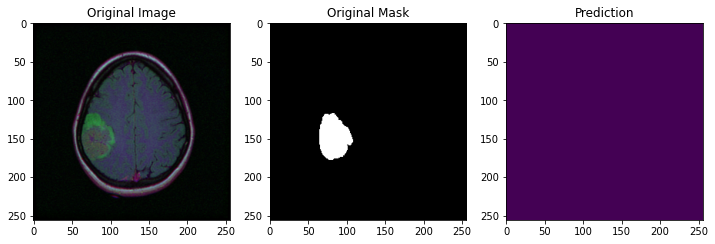

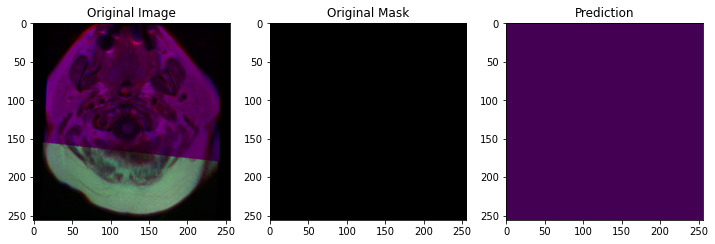

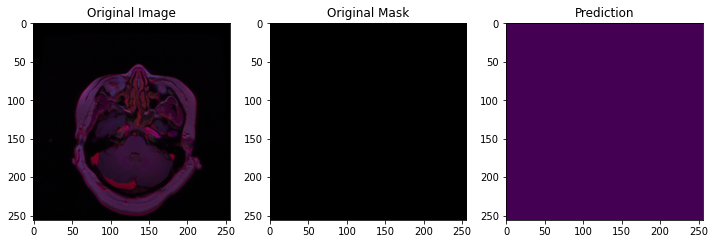

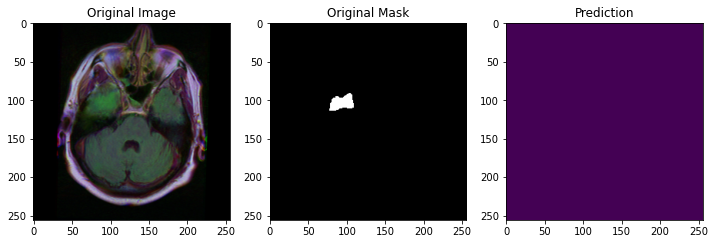

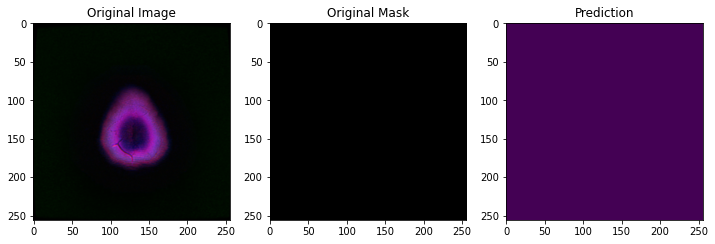

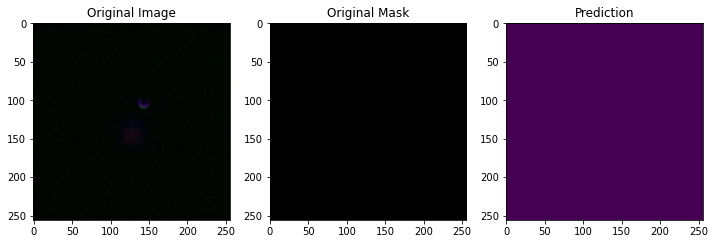

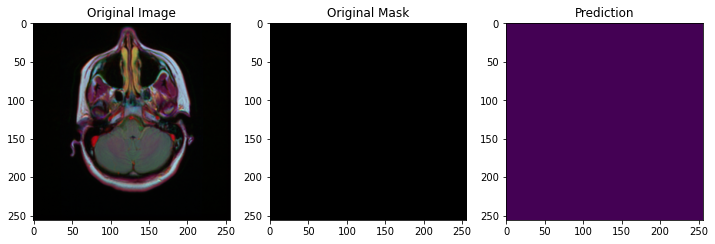

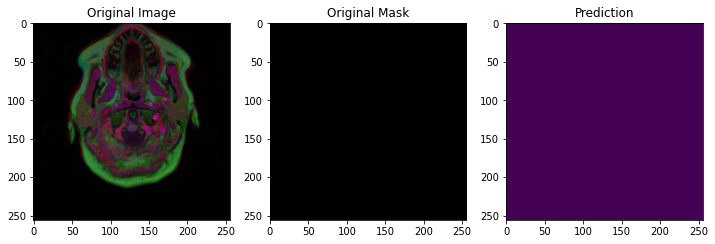

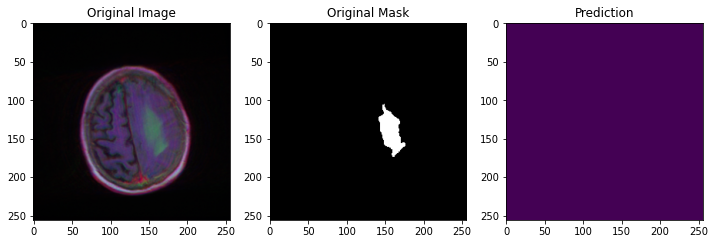

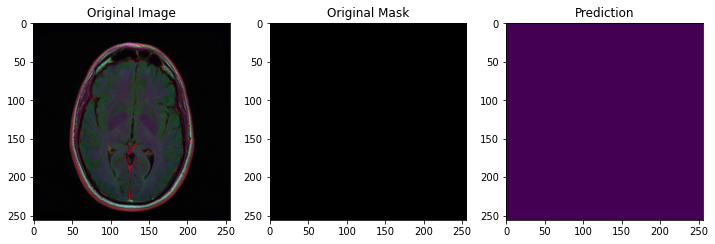

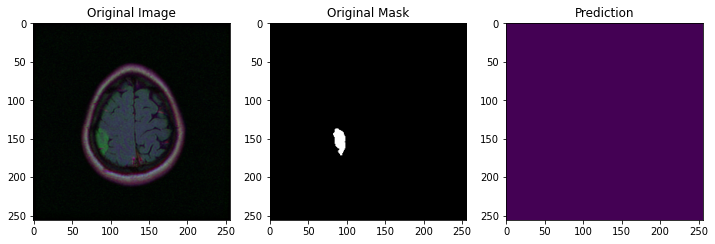

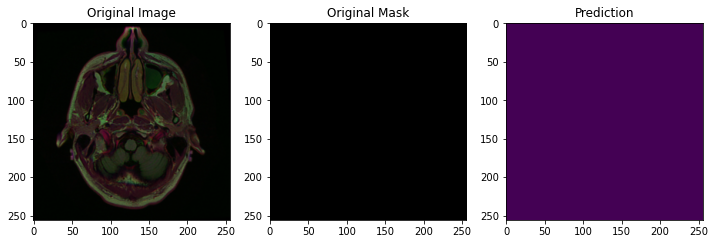

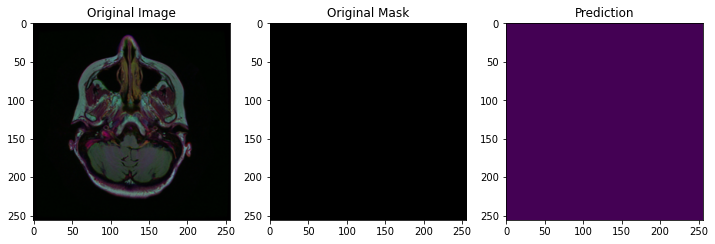

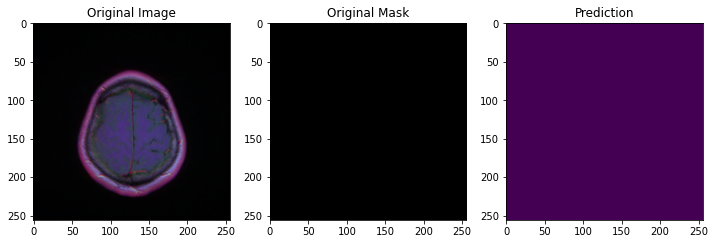

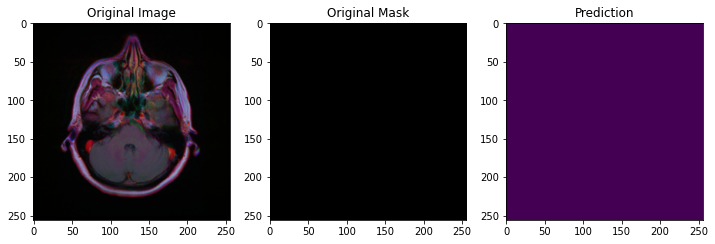

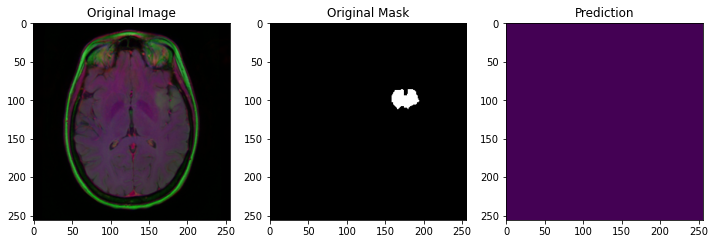

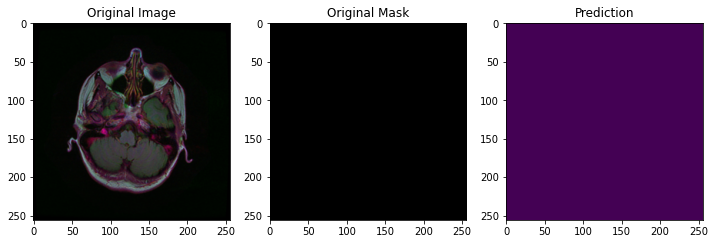

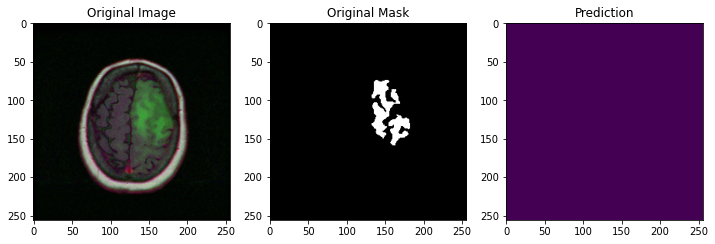

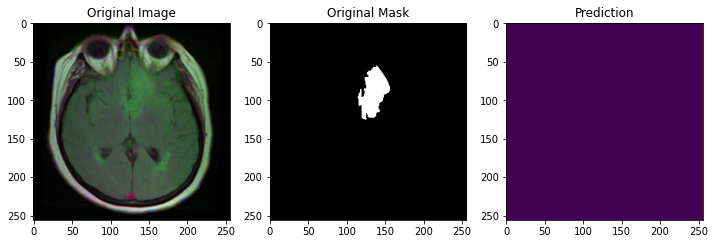

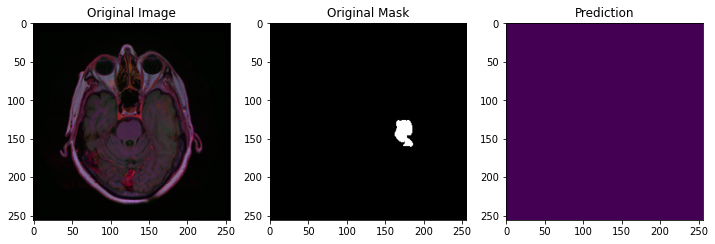

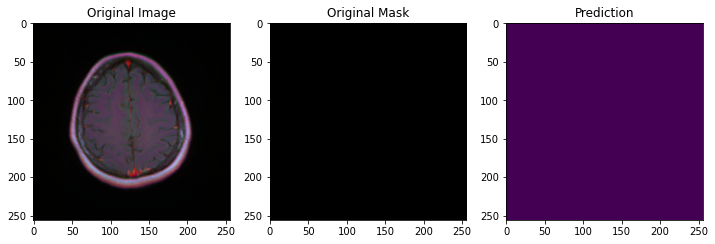

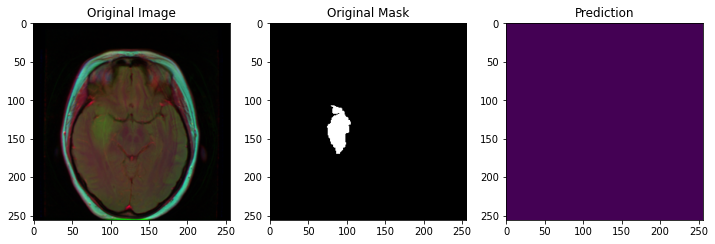

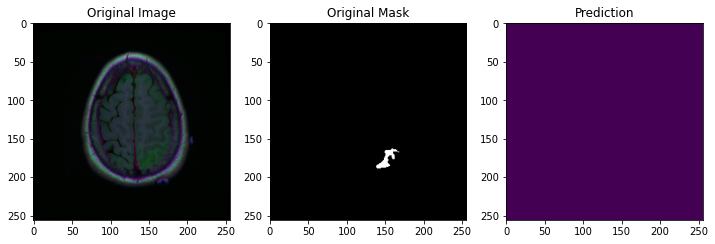

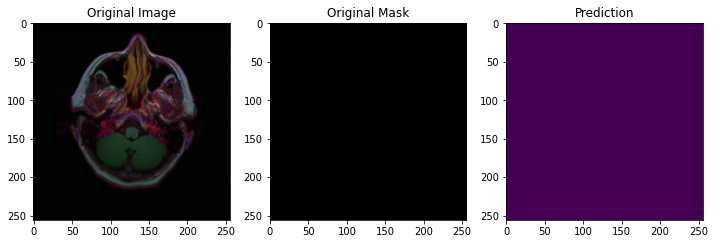

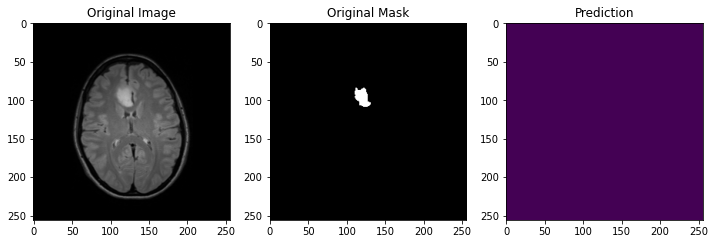

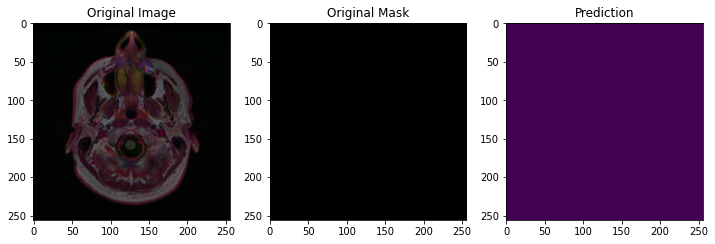

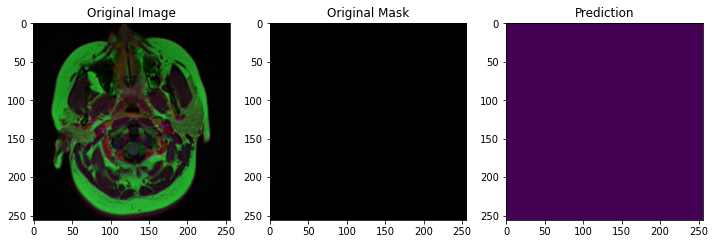

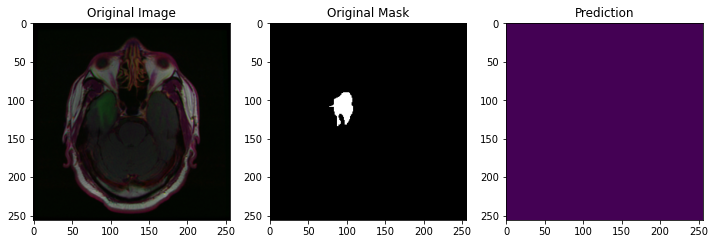

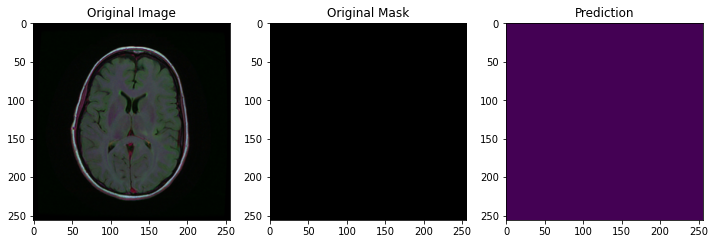

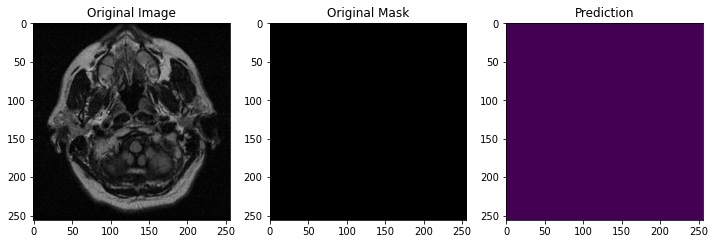

In [30]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

In [31]:
print(history.history.keys())

dict_keys(['loss', 'iou', 'dice_coef', 'accuracy', 'val_loss', 'val_iou', 'val_dice_coef', 'val_accuracy', 'lr'])


In [32]:
loss = history.history["loss"]  # loss function (MSE)
acc = history.history["accuracy"] 

In [33]:
print("Accuracy by UNet: ",results[2]*100,"%")

Accuracy by UNet:  46.51266932487488 %


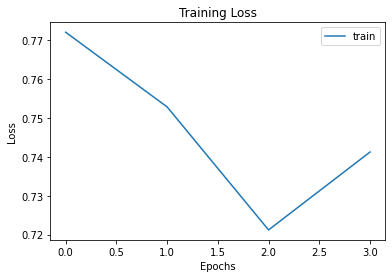

In [34]:
epoch = np.arange(EPOCHS)
plt.plot(epoch, loss)
# plt.plot(epoch, val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(['train', 'val'])

Text(0.5, 1.0, 'Training Accuracy')

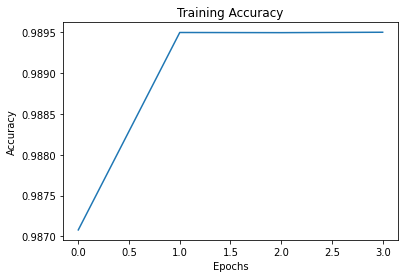

In [35]:
epoch = np.arange(EPOCHS)
plt.plot(epoch, acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

In [36]:
df = pd.read_csv('../input/mri-and-alzheimers/oasis_longitudinal.csv')

In [37]:
df = df.loc[df['Visit']==1] # use first visit data only because of the analysis we're doing
df = df.reset_index(drop=True) # reset index after filtering first visit data
df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) # Target variable
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1) # Drop unnecessary columns

In [38]:
# bar drawing function
def bar_chart(feature):
    Demented = df[df['Group']==1][feature].value_counts()
    Nondemented = df[df['Group']==0][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))

**MALE FEMALE**

Text(0.5, 1.0, 'Gender and Demented rate')

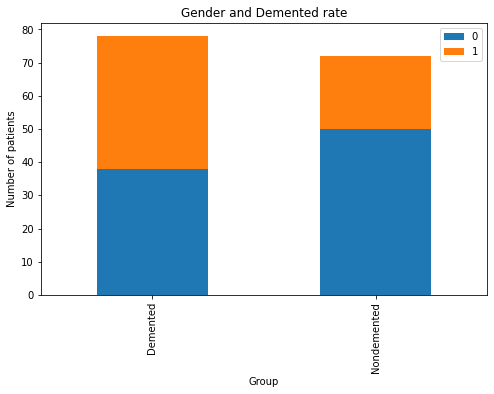

In [39]:
# Gender  and  Group ( Female=0, Male=1)
bar_chart('M/F')
plt.xlabel('Group')
plt.ylabel('Number of patients')
plt.legend()
plt.title('Gender and Demented rate')

**DISTRIBUTION DENSITY**

(15.3, 30.0)

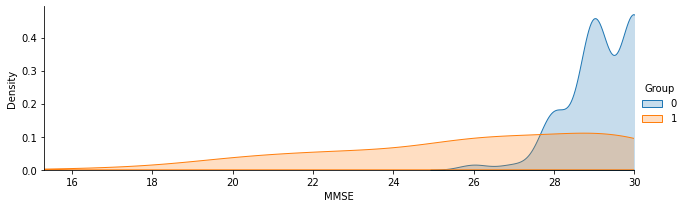

In [40]:
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'MMSE',shade= True)
facet.set(xlim=(0, df['MMSE'].max()))
facet.add_legend()
plt.xlim(15.30)

(0.6, 0.9)

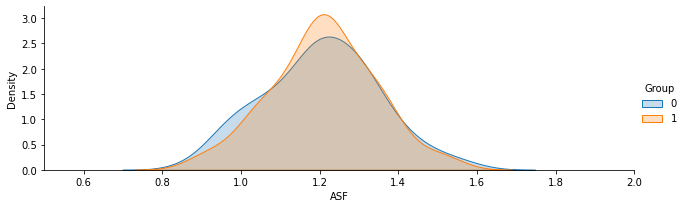

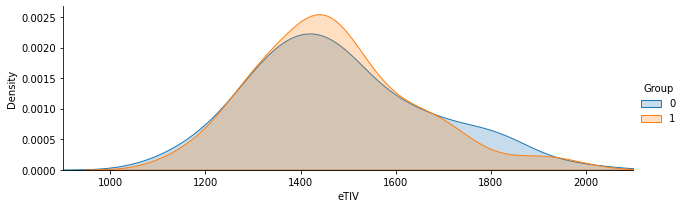

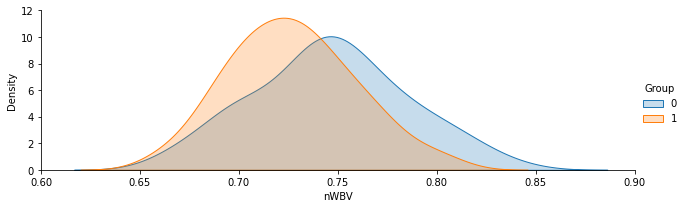

In [41]:
#bar_chart('ASF') = Atlas Scaling Factor
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'ASF',shade= True)
facet.set(xlim=(0, df['ASF'].max()))
facet.add_legend()
plt.xlim(0.5, 2)

#eTIV = Estimated Total Intracranial Volume
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'eTIV',shade= True)
facet.set(xlim=(0, df['eTIV'].max()))
facet.add_legend()
plt.xlim(900, 2100)

#'nWBV' = Normalized Whole Brain Volume
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'nWBV',shade= True)
facet.set(xlim=(0, df['nWBV'].max()))
facet.add_legend()
plt.xlim(0.6,0.9)

(50.0, 100.0)

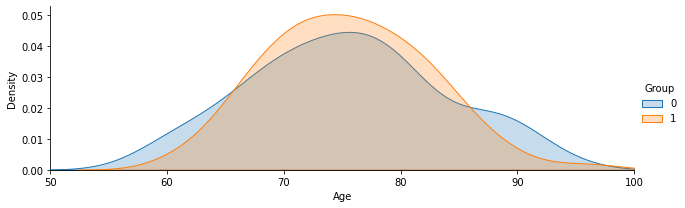

In [42]:
#AGE. Nondemented =0, Demented =0
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()
plt.xlim(50,100)

(0.0, 0.16)

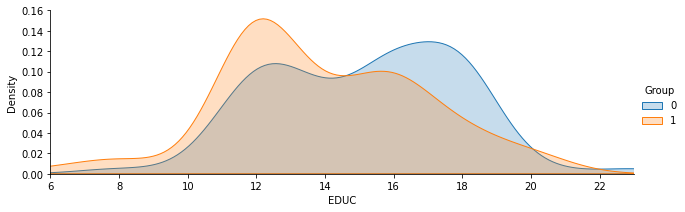

In [43]:
#'EDUC' = Years of Education
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'EDUC',shade= True)
facet.set(xlim=(df['EDUC'].min(), df['EDUC'].max()))
facet.add_legend()
plt.ylim(0, 0.16)

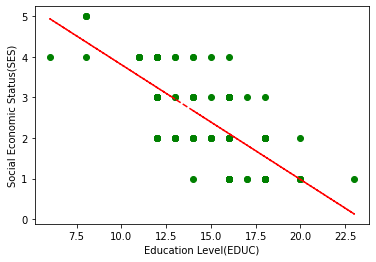

In [44]:
# Draw scatter plot between EDUC and SES
x = df['EDUC']
y = df['SES']

ses_not_null_index = y[~y.isnull()].index
x = x[ses_not_null_index]
y = y[ses_not_null_index]

# Draw trend line in red
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, y, 'go', x, p(x), "r--")
plt.xlabel('Education Level(EDUC)')
plt.ylabel('Social Economic Status(SES)')

plt.show()

In [45]:
df.groupby(['EDUC'])['SES'].median()

EDUC
6     4.0
8     5.0
11    4.0
12    3.0
13    2.0
14    3.0
15    2.0
16    2.0
17    1.0
18    2.0
20    1.0
23    1.0
Name: SES, dtype: float64

In [46]:
df["SES"].fillna(df.groupby("EDUC")["SES"].transform("median"), inplace=True)
# I confirm there're no more missing values and all the 150 data were used.
pd.isnull(df['SES']).value_counts()

False    150
Name: SES, dtype: int64

In [47]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import cross_val_score

In [48]:
# Dataset with imputation
Y = df['Group'].values # Target for the model
X = df[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

**DETECTION OF ALZHEIMER'S DUE TO PRESENCE OF TUMOUR**

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
acc = [] # list to store all performance metric

**Logistic Regression**

In [50]:
best_score=0
kfolds=5 # set the number of folds

for c in [0.001, 0.1, 1, 10, 100]:
    logRegModel = LogisticRegression(C=c)
    # perform cross-validation
    scores = cross_val_score(logRegModel, X_trainval, Y_trainval, cv=kfolds, scoring='accuracy') # Get recall for each parameter setting
    
    # compute mean cross-validation accuracy
    score = np.mean(scores)
    
    # Find the best parameters and score
    if score > best_score:
        best_score = score
        best_parameters = c

# rebuild a model on the combined training and validation set
SelectedLogRegModel = LogisticRegression(C=best_parameters).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedLogRegModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedLogRegModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for regularization (C) is: ", best_parameters)
print("Test accuracy (F1 Score) with best C parameter is", test_score)
print("Test recall with the best C parameter is", test_recall)
print("Test AUC with the best C parameter is", test_auc)
m = 'Logistic Regression (w/ imputation)'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.7339920948616602
Best parameter for regularization (C) is:  100
Test accuracy (F1 Score) with best C parameter is 0.7894736842105263
Test recall with the best C parameter is 0.7
Test AUC with the best C parameter is 0.7944444444444444


**SVM**

In [51]:
best_score = 0

for c_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter C
    for gamma_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter gamma
        for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']: # iterate over the values we need to try for the kernel parameter
            svmModel = SVC(kernel=k_parameter, C=c_paramter, gamma=gamma_paramter) #define the model
            # perform cross-validation
            scores = cross_val_score(svmModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
            # the training set will be split internally into training and cross validation

            # compute mean cross-validation accuracy
            score = np.mean(scores)
            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score #store the score 
                best_parameter_c = c_paramter #store the parameter c
                best_parameter_gamma = gamma_paramter #store the parameter gamma
                best_parameter_k = k_parameter
            

# rebuild a model with best parameters to get score 
SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedSVMmodel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test recall with the best parameter is", test_auc)

m = 'SVM'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on cross validation set is: 0.7687747035573123
Best parameter for c is:  100
Best parameter for gamma is:  0.1
Best parameter for kernel is:  rbf
Test accuracy with the best parameters is 0.8157894736842105
Test recall with the best parameters is 0.7
Test recall with the best parameter is 0.8222222222222222


**Decision Tree**

In [52]:
best_score = 0

for md in range(1, 9): # iterate different maximum depth values
    # train the model
    treeModel = DecisionTreeClassifier(random_state=0, max_depth=md, criterion='gini')
    # perform cross-validation
    scores = cross_val_score(treeModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
    
    # compute mean cross-validation accuracy
    score = np.mean(scores)
    
    # if we got a better score, store the score and parameters
    if score > best_score:
        best_score = score
        best_parameter = md

# Rebuild a model on the combined training and validation set        
SelectedDTModel = DecisionTreeClassifier(max_depth=best_parameter).fit(X_trainval_scaled, Y_trainval )

test_score = SelectedDTModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedDTModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for the maximum depth is: ", best_parameter)
print("Test accuracy with best parameter is ", test_score)
print("Test recall with best parameters is ", test_recall)
print("Test AUC with the best parameter is ", test_auc)

m = 'Decision Tree'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])


Best accuracy on validation set is: 0.7770750988142293
Best parameter for the maximum depth is:  1
Test accuracy with best parameter is  0.8157894736842105
Test recall with best parameters is  0.65
Test AUC with the best parameter is  0.825


In [53]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(SelectedDTModel.feature_importances_)]).T

Feature importance: 


array([['M/F', '0.0'],
       ['Age', '0.0'],
       ['EDUC', '0.0'],
       ['SES', '0.0'],
       ['MMSE', '1.0'],
       ['eTIV', '0.0'],
       ['nWBV', '0.0'],
       ['ASF', '0.0']], dtype='<U32')

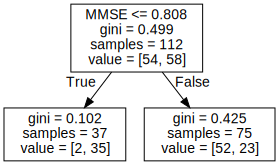

In [54]:
from sklearn.tree import export_graphviz
import graphviz 
dot_data=export_graphviz(SelectedDTModel, feature_names=X_trainval.columns.values.tolist(),out_file=None)
graph = graphviz.Source(dot_data)  
graph 

**Random Forest**

In [55]:
best_score = 0

for M in range(2, 15, 2): # combines M trees
    for d in range(1, 9): # maximum number of features considered at each split
        for m in range(1, 9): # maximum depth of the tree
            # train the model
            # n_jobs(4) is the number of parallel computing
            forestModel = RandomForestClassifier(n_estimators=M, max_features=d, n_jobs=4,
                                          max_depth=m, random_state=0)
        
            # perform cross-validation
            scores = cross_val_score(forestModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

            # compute mean cross-validation accuracy
            score = np.mean(scores)

            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score
                best_M = M
                best_d = d
                best_m = m

# Rebuild a model on the combined training and validation set        
SelectedRFModel = RandomForestClassifier(n_estimators=M, max_features=d,
                                          max_depth=m, random_state=0).fit(X_trainval_scaled, Y_trainval )

PredictedOutput = SelectedRFModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameters of M, d, m are: ", best_M, best_d, best_m)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'Random Forest'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])


Best accuracy on validation set is: 0.8035573122529645
Best parameters of M, d, m are:  2 5 7
Test accuracy with the best parameters is 0.868421052631579
Test recall with the best parameters is: 0.8
Test AUC with the best parameters is: 0.8722222222222222


**AdaBoost**

In [56]:
best_score = 0

for M in range(2, 15, 2): # combines M trees
    for lr in [0.0001, 0.001, 0.01, 0.1, 1]:
        # train the model
        boostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0)

        # perform cross-validation
        scores = cross_val_score(boostModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

        # compute mean cross-validation accuracy
        score = np.mean(scores)

        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_M = M
            best_lr = lr

# Rebuild a model on the combined training and validation set        
SelectedBoostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0).fit(X_trainval_scaled, Y_trainval )

PredictedOutput = SelectedBoostModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter of M is: ", best_M)
print("best parameter of LR is: ", best_lr)
print("Test accuracy with the best parameter is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'AdaBoost'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.7770750988142293
Best parameter of M is:  2
best parameter of LR is:  0.0001
Test accuracy with the best parameter is 0.868421052631579
Test recall with the best parameters is: 0.65
Test AUC with the best parameters is: 0.825


In [57]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(SelectedBoostModel.feature_importances_)]).T

Feature importance: 


array([['M/F', '0.07142857142857142'],
       ['Age', '0.14285714285714285'],
       ['EDUC', '0.21428571428571427'],
       ['SES', '0.07142857142857142'],
       ['MMSE', '0.14285714285714285'],
       ['eTIV', '0.21428571428571427'],
       ['nWBV', '0.14285714285714285'],
       ['ASF', '0.0']], dtype='<U32')